# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Открытие файла с данными и изучение общей информации

In [1]:
import warnings
warnings.filterwarnings('ignore')#скрытие предупреждений
import pandas as pd

df = pd.read_csv('/datasets/data.csv')
display(df.head(10))


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [2]:
df.info()# получение общуей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Ознакомившись с таблицей, можно сделать следующие выводы:

В таблице 12 столбцов. 

Согласно документации к данным:
    
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита


Названия столбцов приведены к единому стилю и не требуют изменения

Требует предобработки:
1. Количество значений в столбцах различается. Значит, в данных есть пропущенные значения в столбцах 'days_employed' и 'total_income'.
2. В столбце 'days_employed' (общий трудовой стаж в днях) имеются отрицательные значения и заметен слишком большой разброс значений. Следует проверить гипотезу, что при выгрузке данных из разных источников возникла ошибка и данные записаны в разном формате. Часть данных представлена не в днях, а более мелких едницах измерения.
3. Тип данных в стобцах 'days_employed' и 'total_income' необходтмо заменить на целочисленный.
3. Необходимо проверить таблицу на явные и неявные дубликаты. Сразу заметны различия в написании в столбце 'education'.

## Предобработка данных

### Обработка пропусков

Сначала определю количество пропущенных значений с помощью методов isna() и sum():

In [3]:
df.isna().sum()# подсчёт пропусков

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [4]:
#определяние диапозона разброса значений в столбце 'days_employed'
df['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

Заметен не только очень широкий разброс значений, но и отрицательные величины, что не соответсвует описанию столбца 'days_employed' (общий трудовой стаж в днях). Посмотрю на разброс значений с помощью гистограммы.

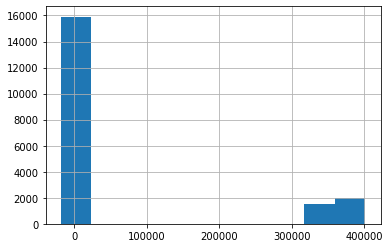

In [5]:
#построение гистограммы для 'days_employed'
df['days_employed'].hist() 

По гистограмме видно, что часть значений больше 300000, значит эти значения представлены не в днях, а в более мелкой единице измерения - часах.
Таким образом, необходимо привести отрицательные значения столбца к модулю, а значения, выходящие за предел 300000 - перевести в часы.

In [6]:
#беру значения по модулю
df['days_employed'] = abs(df['days_employed'])

#применяю логическую индексацию с методом loc(), для перевода значений в часах в дни:

df.loc[df['days_employed'] > 300000, 'days_employed'] = df.loc[df['days_employed'] > 300000, 'days_employed'] /24

In [7]:
df['days_employed'].describe() # проверка получившегося разброса значений

count    19351.000000
mean      4641.641176
std       5355.964289
min         24.141633
25%        927.009265
50%       2194.220567
75%       5537.882441
max      18388.949901
Name: days_employed, dtype: float64

Значения распределяются корректно. Минимальное значение больше 0, максимальное составляет 50 лет трудового стажа. Гипотеза об ошибке при выгрузке подтвердилась, перевод аномально больших значений в часы привел к корректному распределнию данных.

Далее необходимо заполнить пропущенные значения в столбцах 'days_employed' и 'total_income'. Так как выборка не является однородной, заполнение должно происходить не по среднему арифметическому, а по медианному значению. Но просто заполнить медианным значением по столбцам будет не совсем корректно. Проверим гипотезу, что пропуски зависят от семейного положения 'family_status' или от типа дохода 'income_type'

In [8]:
df['missing_days_employed'] = df['days_employed'].isna() # пропуски столбца 'days_employed'
df['missing_total_income'] = df['total_income'].isna()  # пропуски столбца 'total_income'

#группировка пропущенных значений по семейному положению и подсчет среднего по группам
display(df.groupby('family_status').agg({'missing_days_employed' : 'mean',
                                         'missing_total_income' : 'mean'}).sort_values(by = 'missing_days_employed', 
                                                                               ascending =False))
#группировка пропущенных значений по типу дохода и подсчет среднего по группам
display(df.groupby('income_type').agg({'missing_days_employed' : 'mean',
                                       'missing_total_income' : 'mean'}).sort_values(by = 'missing_days_employed', 
                                                                               ascending =False))




,missing_days_employed,missing_total_income
family_status,,
гражданский брак,0.105818,0.105818
Не женат / не замужем,0.102382,0.102382
женат / замужем,0.099919,0.099919
вдовец / вдова,0.098958,0.098958
в разводе,0.093724,0.093724


,missing_days_employed,missing_total_income
income_type,,
предприниматель,0.500000,0.500000
пенсионер,0.107106,0.107106
госслужащий,0.100754,0.100754
компаньон,0.099902,0.099902
сотрудник,0.099379,0.099379
безработный,0.000000,0.000000
в декрете,0.000000,0.000000
студент,0.000000,0.000000


Занятно, что категории с пропусками совпадают для обоих столбцов. Можно сделать вывод, что пропуски не случайны. 
Процент пропусков при группировке по семейному положению приблизительно схож. При группировке по типу дохода - видны перекосы. Т.е. наличие пропусков зависит от типа дохода. Таким образом логично заполнять пропуски для обоих столбцов медианным значением с группировкой по типу дохода 'income_type':

In [9]:
#заполнение пропусков в столбце 'days_employed' едианным значением с группировкой по 'income_type'
print('Трудовой стаж. Пропуски до:', df['days_employed'].isna().sum())

for income in df['income_type'].unique():
    median = df.loc[df['income_type'] == income , 'days_employed'].median()
    df.loc[(df['days_employed'].isna()) & (df['income_type'] == income), 'days_employed'] = median
           
print('Трудовой стаж. Пропуски после:', df['days_employed'].isna().sum())

Трудовой стаж. Пропуски до: 2174
Трудовой стаж. Пропуски после: 0


In [10]:
#заполнение пропусков в столбце 'total_income' едианным значением с группировкой по 'income_type'
print('Ежемесячный доход. Пропуски до:', df['total_income'].isna().sum())

for income in df['income_type'].unique():
    median = df.loc[df['income_type'] == income , 'total_income'].median()
    df.loc[(df['total_income'].isna()) & (df['income_type'] == income), 'total_income'] = median
           
print('Ежемесячный доход. Пропуски после:', df['total_income'].isna().sum())

Ежемесячный доход. Пропуски до: 2174
Ежемесячный доход. Пропуски после: 0


**Вывод**

При ознакомлении с таблицей, были обнаружены пропущенные значения в столбцах 'days_employed'(общий трудовой стаж в днях) и 'total_income'(ежемесячный доход). 
Было выясненно, что распределение пропусков зависит от типа дохода 'income_type', причем для обоих столбцов процент пропусков оказался одинаковым. Таким образом, можно сделать вывод, что пропуски в 'days_employed' и 'total_income' не случайны и находятся в прямой зависимости друг от друга. 
Была выявлена группа "предприниматель" с наибольшим процентом пропусков - 50% от общего числа значений.
Пропуски были заполнены медианным значением (так как выборка не однородка) с группировкой данных по типу дохода 'income_type'. Так получилось сохранить репрезентативность выборки для заполняемых данных.

В столбце 'days_employed' (общий трудовой стаж в днях) имелись отрицательные значения и был заметен слишком большой разброс значений. Возможная причина - выгрузка происходила из разных систем с разными единицами измерения. Значения столбца были приведены к единому формату - положительные значения в часах.



### Замена типа данных

Необходимо заменить тип данных в столбцах 'days_employed' и 'total_income' на целочисленный (int64). 
Так как значения столбцов имеют формат вещественных чисел (float64), для перевода буду использовать метод astype(). 
Для проверки вызову метод info()


In [11]:
df['days_employed'] = df['days_employed'].astype(int)
df['total_income'] = df['total_income'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
children                 21525 non-null int64
days_employed            21525 non-null int64
dob_years                21525 non-null int64
education                21525 non-null object
education_id             21525 non-null int64
family_status            21525 non-null object
family_status_id         21525 non-null int64
gender                   21525 non-null object
income_type              21525 non-null object
debt                     21525 non-null int64
total_income             21525 non-null int64
purpose                  21525 non-null object
missing_days_employed    21525 non-null bool
missing_total_income     21525 non-null bool
dtypes: bool(2), int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

В столбцах 'days_employed' и 'total_income' был заменен вещественный тип данных на целочисленный методом astype(). Выбор метода обусловлен изначальным типом данных столбцов. (метод to_nomeric() применяется для строковых значений и превращает значение столбца в значение типа float64, т.е. не применим к данной задаче).


### Обработка дубликатов

При первом ознакомлении с таблицей были сразу видны дубликаты с разным регистром в столбце 'education'. 
Поэтому приведу значения столбца 'education' к нижнему регистру методом lower(), а затем проверю на явные дубликаты:

In [12]:
df['education'] = df['education'].str.lower()
# подсчёт явных дубликатов
print (df.duplicated().sum())


71


In [13]:
# удаление явных дубликатов (с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True)
print (df.duplicated().sum())

0


Проверим нужные для исследования столбцы на неявные дубликаты и артефакты. 
Меня интересуют столбцы, которые понадобятся для проверки гипотез, а именно:
- 'children' - наличие детей
- 'family_status' - семейное положение
- 'income_type' - тип занятости
- 'purpose' - цели кредита 


In [14]:
print(df['children'].value_counts()) # проверяю, какие значения встречаются и столбце и их колличество

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


В столбце 'children' дубликатов нет, но найдены значения (20 и -1), которые не отражают действительность - артефакты. Возможная причина - выгрузка из разных систем. Возможно, что '-1' - это иная запись отсутсвия детей, а '20' - это опечатка. Так как данный столбец потребуется для проверки гипотезы о зависимости наличия детей и возврата кредита в срок - обработаю эти значения. Так как нет уверенности в истинном происхождении этих значений - заменю артефакты медианным значением по столбцу. Доля артефактных значений от общего числа слишком мала и в целом такое действие не повлияет на результат исследования, но сохранит среднее столбца.

In [15]:
#заменяю медианным значением артефакты и проверяю 
df.loc[df['children'] == -1, 'children'] = df['children'].median() 
df.loc[df['children'] == 20, 'children'] = df['children'].median()

df['children'] = df['children'].astype(int)

print(df['children'].value_counts())
         

0    14214
1     4808
2     2052
3      330
4       41
5        9
Name: children, dtype: int64


In [16]:
print(df['family_status'].unique()) # дубликатов нет

['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']


In [17]:
print(df['income_type'].unique()) # дубликатов нет

['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']


In [18]:
print(sorted(df['purpose'].unique())) # так как целей много - сразу отсортирую значения по алфавиту для наглядности

['автомобили', 'автомобиль', 'высшее образование', 'дополнительное образование', 'жилье', 'заняться высшим образованием', 'заняться образованием', 'на покупку автомобиля', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'на проведение свадьбы', 'недвижимость', 'образование', 'операции с жильем', 'операции с коммерческой недвижимостью', 'операции с недвижимостью', 'операции со своей недвижимостью', 'покупка жилой недвижимости', 'покупка жилья', 'покупка жилья для сдачи', 'покупка жилья для семьи', 'покупка коммерческой недвижимости', 'покупка недвижимости', 'покупка своего жилья', 'получение высшего образования', 'получение дополнительного образования', 'получение образования', 'приобретение автомобиля', 'профильное образование', 'ремонт жилью', 'свадьба', 'свой автомобиль', 'сделка с автомобилем', 'сделка с подержанным автомобилем', 'строительство жилой недвижимости', 'строительство недвижимости', 'строительство собственной недвижимости', 'сыграть свадьбу']


В столбце 'purpose' много словесных дубликатов, потребуется лемматизация (приведение слова к его словесной форме) для выделения основных категорий целей получения кредита.

**Вывод**

Наличие дубликатов в данных может привести к некорректным результатам, поэтому поиск и удаление дубликатов - очень важная часть исследования.
Был проведен поиск и удаление явных дубликатов и проверка на неявные дубликаты столбцов, необходимых для дальнейшего исследования.
В столбце 'children' были найдены  и обработаны артефакты.
Выявлена необходимость лемматизации значений столбца 'purpose' для выделения основных категорий целей получения кредита.


### Лемматизация

При обработке дубликатов, было выявлена необходимость применение процесса лемматизации для столбца 'purpose' - цели получения кредита. Импортирую библиотеку PyMystem и проведу лемматизацию.

In [33]:
import pymystem3
from pymystem3 import Mystem
m = Mystem()

#создаю список слов, сведенных к лемме
purpose_str = df['purpose'].unique()
lemmas = " ".join(purpose_str)
lemmas = m.lemmatize(lemmas)

#посчитаю частоту появления слов
from collections import Counter
print(Counter(lemmas))



Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


In [34]:
lemmas_purpose = " ".join(df['purpose'])
lemmas_purpose = m.lemmatize(lemmas_purpose)

print(Counter(lemmas_purpose))

Counter({' ': 55023, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'подержать': 853, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'приобретение': 461, 'профильный': 436, 'подержанный': 111, '\n': 1})


Вручную выделю самые частые существительные для определения категорий и напишу функцию, которая будет последовательно лемматизировать каждую ячейку столбца 'purpose' и проверять,к какой из категорий онат относится.

In [21]:
#функция для проверки каждой ячейки столбца 'purpose' и присвоения соответсвующей категории
def categorize(purpose):
    purpose_lemmas = m.lemmatize(purpose)
    if 'недвижимость' in purpose_lemmas or 'жилье' in purpose_lemmas:
        return 'недвижимость'
    if 'автомобиль' in purpose_lemmas:
        return 'автомобиль'
    if 'образование' in purpose_lemmas:
        return 'образование'
    if 'свадьба' in purpose_lemmas:
        return 'свадьба'
    return  'иное'
    
#создаю новый столбец 'category' и с помощью метода apply применяю функцию categorize
df['purpose_category'] = df['purpose'].apply(categorize)
#вывожу результат в виде таблицы из нужных столбцов
display(df.loc[:, ['purpose', 'purpose_category']])

,purpose,purpose_category
0,покупка жилья,недвижимость
1,приобретение автомобиля,автомобиль
2,покупка жилья,недвижимость
3,дополнительное образование,образование
4,сыграть свадьбу,свадьба
...,...,...
21449,операции с жильем,недвижимость
21450,сделка с автомобилем,автомобиль
21451,недвижимость,недвижимость
21452,на покупку своего автомобиля,автомобиль


**Вывод**

Для значений столбца 'purpose' были выделены леммы и определены основные категории целей получения кредита. 
Данный этап очень важен для дальнейшего исследования и ответа на вопрос о влиянии целей на возврат кредита в срок.

### Категоризация данных

Проведу категоризацию данных - объединение избранных данных в произвольные группы по заданному параметру.

Cделаю классификацию по типу для стобцов family_status и education: 

Создадам отдельные «словари», где названию категории будет соответствовать номер. И в будущих таблицах будет возможно обращаться уже не к строке, а к её числовому обозначению. Это полезно сделать для упрощения визуальной работы с таблицей и простоты фильтрации.
В «словаре» возможны дубликаты. Для их удаления применю методы drop_duplicates() и reset_index().


In [22]:
family_status_category = df[['family_status','family_status_id']]
family_status_category = family_status_category.drop_duplicates().reset_index(drop=True)
display(family_status_category.sort_values('family_status_id',ascending=True))


,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


In [23]:
education_category = df[['education','education_id']]
education_category = education_category.drop_duplicates().reset_index(drop=True)
display(education_category.sort_values('education_id',ascending=True))

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


Для категоризации по уровню дохода напишу функцию, которая оценивает размер ежемесячного дохода и присваивает категорию.
Задам следующие параметры:

    * низкий доход - доход ниже и равен половине медианы;
    * высокий доход - больше или равен значению в 1.5 медианы;
    * к среднему доходу отнесу все значения между.

In [24]:
# функция для оценки размера ежемесячного дохода и разделения по категориям
def total_income_categorize(income):
    
    total_income_median = df['total_income'].median()
    
    if income <= total_income_median * 0.5:
        return 'низкий доход'
    if income >= total_income_median * 1.5:
        return 'высокий доход'
    return 'средний доход'


#добавляю столбец, где хранятся результаты применения функции
df['total_income_category'] = df['total_income'].apply(total_income_categorize)
#вывожу статистику по каждой группе
print(df['total_income_category'].value_counts())

средний доход    15555
высокий доход     4320
низкий доход      1579
Name: total_income_category, dtype: int64


**Вывод**

С помощью категоризации были исследованы значения категориальных столбцов, произведена проверка на дубликаты и их удаление. Выделены категории ежемесячного дохода. Эти категории будут необходимы для ответа на вопрос о зависимость между уровнем дохода и возвратом кредита в срок


## Ответы на вопросы

Для обобщения данных и их наглядного представления буду использовать сводные таблицы. С помощью них будет легче ответить на основные вопросы исследования.
Сводные таблицы можно создавать двумя способами:
- с помощью метода pivot_table()
- с помощью цепочки методов groupby() и agg()

На мой взгляд цепочка методов groupby() и agg() более лаконична и понятна в написании кода и выводимом результате. Поэтому буду использовать этот способ.

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [25]:
report_children = df.groupby('children').agg({'debt': ['mean', 'count', 'sum']})
report_children.columns = ['% невозврата', 'кол-во заемщиков', 'кол-во должников']
report_children = report_children.sort_values(by = '% невозврата', ascending = False)
report_children.style.format({'% невозврата' : '{:.2%}'})


,% невозврата,кол-во заемщиков,кол-во должников
children,,,
4,9.76%,41,4
2,9.45%,2052,194
1,9.23%,4808,444
3,8.18%,330,27
0,7.54%,14214,1072
5,0.00%,9,0


**Вывод**

Процент невозврата кредита у заемщиков без детей ниже чем у заемщиков с детьми, причем зависимости процента невозврата от количество детей не наблюдается.
Можно сделать вывод, наличие детей влияет на факт возврата кредита в срок. Люди с детьми имеют задолженности по кредитам чаще. Это может быть связанно с тем, что люди с детьми имеют больше необходимых статей расходов и чаще сталкиваются с дополнительными расходами.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [26]:
report_family_status = df.groupby('family_status').agg({'debt': ['mean', 'count', 'sum']})
report_family_status.columns = ['% невозврата', 'кол-во заемщиков', 'кол-во должников']
report_family_status = report_family_status.sort_values(by = '% невозврата', ascending = False)
report_family_status.style.format({'% невозврата' : '{:.2%}'})

,% невозврата,кол-во заемщиков,кол-во должников
family_status,,,
Не женат / не замужем,9.75%,2810,274
гражданский брак,9.35%,4151,388
женат / замужем,7.55%,12339,931
в разводе,7.11%,1195,85
вдовец / вдова,6.57%,959,63


 **Вывод**

Наибольший процент невозврата по кредитам имеют 'неженатые' и находящиеся в 'гражданском браке'. Заемщики из категорий 'женат / замужем','в разводе', 'вдовец / вдова' являются более надежными. Возможно это связанно с более взвешенным подходом к долговым обязательствам и планированием бюджета.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [27]:
report_income = df.groupby('total_income_category').agg({'debt': ['mean', 'count', 'sum']})
report_income.columns = ['% невозврата', 'кол-во заемщиков', 'кол-во должников' ]
report_income = report_income.sort_values(by = '% невозврата', ascending = False)
report_income.style.format({'% невозврата' : '{:.2%}'})

,% невозврата,кол-во заемщиков,кол-во должников
total_income_category,,,
средний доход,8.54%,15555,1328
высокий доход,7.04%,4320,304
низкий доход,6.90%,1579,109


**Вывод**

Процент невозврата по категории 'средний доход' самый высокий, но это и самая многочисленная категория. Можно сделать вывод, что заемщики с высоким доходом реже имеют задолженности по кредитам. Низкий процент невозврата у заемщиков с доходом меньше среднего может быть связан с тем, что им в целом реже дают кредиты и они проходят более строгий отбор при кридитовании.

- Как разные цели кредита влияют на его возврат в срок?

In [28]:
report_purpose= df.groupby('purpose_category').agg({'debt': ['mean', 'count', 'sum']})
report_purpose.columns = ['% невозврата', 'кол-во заемщиков', 'кол-во должников' ]
report_purpose = report_purpose.sort_values(by = '% невозврата', ascending = False)
report_purpose.style.format({'% невозврата' : '{:.2%}'})

,% невозврата,кол-во заемщиков,кол-во должников
purpose_category,,,
автомобиль,9.36%,4306,403
образование,9.22%,4013,370
свадьба,8.00%,2324,186
недвижимость,7.23%,10811,782


**Вывод**

Самый высокий процент невозврата у автокредита и кредита на образование. Самый низкий у кредита на недвижимость. Это может быть связано с условиями займа. Люди чаще бояться потерять находящуюся в залоге банка недвижимость, чем нарушить иные долговые обязательства.

## Шаг 4. Общий вывод

Данное исследование было подготовлено для кредитного отдела банка с целью определения влияния семейного положения и количества детей на факт возврата кредита в срок и дальнейшего построения модели кредитного скоринга.
Были сделаны следующие выводы:

1. Наличие детей увеличивает вероятность невозврата кредита. При этом явной завсимости от количества детей не выявлено. Люди с детьми имеют больше необходимых статей расходов и чаще сталкиваются с дополнительными расходами, поэтому имеют задолженности чаще.

2. Наибольший процент невозврата по кредитам имеют 'неженатые' и находящиеся в 'гражданском браке'. Заемщики из категорий 'женат / замужем','в разводе', 'вдовец / вдова' являются более надежными. Возможно это связанно с более взвешенным подходом к долговым обязательствам и планированием бюджета.
Но нужно заметить, что возможно выделение категории 'молодая семья' повлияло бы на результат, так как в такой категории дети появляются чаще и появление новых статей расходов может повлиять на увеличение процента невозврата кредита.

Также была провена зависимость уровня дохода на возврат кредита и влияние целей кредита на его возврат.

Заемщики с высоким доходом реже имеют задолженности по кредитам. Заемщики с низким доходом проходят более строгий отбор при выдаче кредита и поэтому процент невозврата по этой категории низкий.

Самый высокий процент невозврата у автокредита и кредита на образование. Самый низкий у кредита на недвижимость. Это может быть связано с условиями займа. Люди чаще бояться потерять находящуюся в залоге банка недвижимость, чем нарушить иные долговые обязательства.



 